In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Models
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.svm import SVR
from mlxtend.regressor import StackingCVRegressor
from xgboost import XGBRegressor

import warnings
warnings.filterwarnings('ignore')

In [29]:
# Load data
train_X = pd.read_csv('../data/processed/train_X.csv')
train_y = pd.read_csv('../data/processed/train_y.csv')
test_X = pd.read_csv('../data/processed/test_X.csv')

In [30]:
print(train_X.shape,test_X.shape)

(1457, 219) (1459, 219)


## Model setup

In [81]:
# XGBoost Regressor
xgboost = XGBRegressor(learning_rate=0.01,
                       n_estimators=6000,
                       max_depth=4,
                       min_child_weight=0,
                       gamma=0.6,
                       subsample=0.7,
                       colsample_bytree=0.7,
                       objective='reg:squarederror',
                       nthread=-1,
                       scale_pos_weight=1,
                       seed=27,
                       reg_alpha=0.00006,
                       random_state=42)

# Support Vector Regressor
svr = make_pipeline(RobustScaler(), SVR(C= 20, epsilon= 0.008, gamma=0.0003))

# Gradient Boosting Regressor
gbr = GradientBoostingRegressor(n_estimators=6000,
                                learning_rate=0.01,
                                max_depth=4,
                                max_features='sqrt',
                                min_samples_leaf=15,
                                min_samples_split=10,
                                loss='huber',
                                random_state=42)  

# Random Forest Regressor
rf = RandomForestRegressor(n_estimators=1200,
                          max_depth=15,
                          min_samples_split=5,
                          min_samples_leaf=5,
                          max_features=None,
                          oob_score=True,
                          random_state=42)

# Stack up all the models above, optimized using xgboost
stack_gen = StackingCVRegressor(regressors=(xgboost, svr, gbr, rf),
                                meta_regressor=gbr,
                                use_features_in_secondary=True,
                                random_state=42)

In [82]:
# Setup cross validation folds
kf = KFold(n_splits=5, random_state=42, shuffle=True)

In [84]:
# Define error metrics
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

def cv_rmse(model, X=train_X):
    rmse = np.sqrt(-cross_val_score(model, train_X, train_y, scoring="neg_mean_squared_error", cv=kf))
    return (rmse)

## Model training

Get cross validation scores for each model

In [85]:
scores={}

In [86]:
score = cv_rmse(xgboost)
print("xgboost: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['xgb'] = (score.mean(), score.std())

xgboost: 0.1403 (0.0097)


In [87]:
score = cv_rmse(svr)
print("SVR: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['svr'] = (score.mean(), score.std())

SVR: 0.1343 (0.0116)


In [88]:
score = cv_rmse(rf)
print("rf: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['rf'] = (score.mean(), score.std())

rf: 0.1408 (0.0100)


In [89]:
score = cv_rmse(gbr)
print("gbr: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['gbr'] = (score.mean(), score.std())

gbr: 0.1134 (0.0096)


In [92]:
# score = np.sqrt(-cross_val_score(stack_gen, np.array(train_X), np.array(train_y), scoring="neg_mean_squared_error", cv=kf))
print("stack: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['stack'] = (score.mean(), score.std())

stack: 0.1124 (0.0097)


Stacked model performs the best.

### Fitting models

In [93]:
print('stack_gen')
stack_gen_model = stack_gen.fit(np.array(train_X), np.array(train_y))

print('xgboost')
xgb_model_full_data = xgboost.fit(train_X,train_y)

print('svr')
svr_model_full_data = svr.fit(train_X, train_y)

print('RandomForest')
rf_model_full_data = rf.fit(train_X, train_y)

print('GradientBoosting')
gbr_model_full_data = gbr.fit(train_X, train_y)

stack_gen
xgboost
svr
RandomForest
GradientBoosting


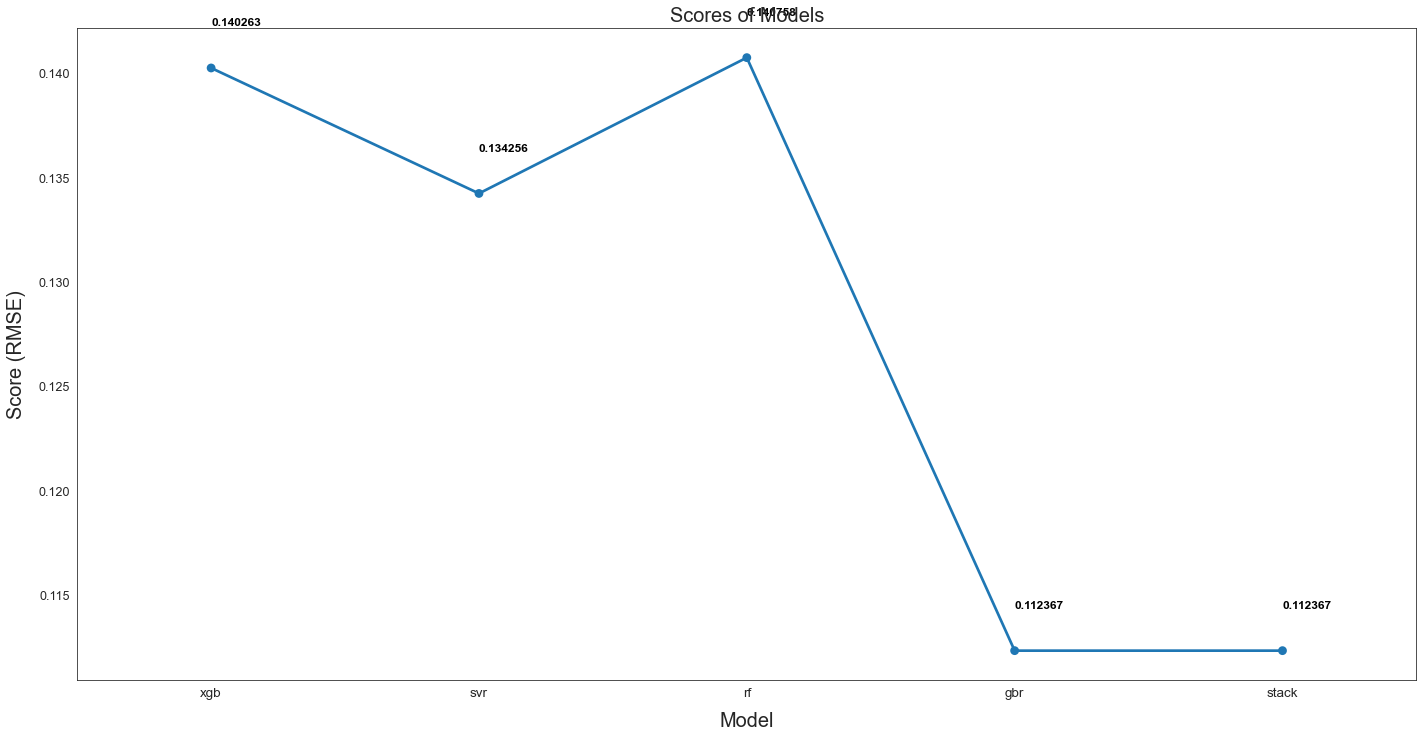

In [108]:
# Plot the predictions for each model
sns.set_style("white")
fig = plt.figure(figsize=(24, 12))

ax = sns.pointplot(x=list(scores.keys()), y=[score for score, _ in scores.values()], markers=['o'], linestyles=['-'])
for i, score in enumerate(scores.values()):
    ax.text(i, score[0] + 0.002, '{:.6f}'.format(score[0]), horizontalalignment='left', size='large', color='black', weight='semibold')

plt.ylabel('Score (RMSE)', size=20, labelpad=12.5)
plt.xlabel('Model', size=20, labelpad=12.5)
plt.tick_params(axis='x', labelsize=13.5)
plt.tick_params(axis='y', labelsize=12.5)

plt.title('Scores of Models', size=20)

plt.show()

I will use the stacked model which has the lowest rmse.

## Make a predictions

In [113]:
# determine the threshold for missing values
def percent_missing(df):
    data = pd.DataFrame(df)
    df_cols = list(pd.DataFrame(data))
    dict_x = {}
    for i in range(0, len(df_cols)):
        dict_x.update({df_cols[i]: round(data[df_cols[i]].isnull().mean()*100,2)})
    
    return dict_x

missing = percent_missing(test_X)
df_miss = sorted(missing.items(), key=lambda x: x[1], reverse=True)
print('Percent of missing data')
df_miss[0:10]

Percent of missing data


[('BsmtFullBath', 0.14),
 ('BsmtHalfBath', 0.14),
 ('BsmtFinSF1', 0.07),
 ('BsmtFinSF2', 0.07),
 ('BsmtUnfSF', 0.07),
 ('TotalBsmtSF', 0.07),
 ('GarageCars', 0.07),
 ('GarageArea', 0.07),
 ('MSSubClass', 0.0),
 ('LotArea', 0.0)]

In [114]:
# Some of the non-numeric predictors are stored as numbers; convert them into strings 
test_X['MSSubClass'] = test_X['MSSubClass'].apply(str)

In [117]:
def handle_missing(features):
    # We have no particular intuition around how to fill in the rest of the categorical features
    # So we replace their missing values with None
    objects = []
    for i in features.columns:
        if features[i].dtype == object:
            objects.append(i)
    features.update(features[objects].fillna('None'))
        
    # And we do the same thing for numerical features, but this time with 0s
    numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    numeric = []
    for i in features.columns:
        if features[i].dtype in numeric_dtypes:
            numeric.append(i)
    features.update(features[numeric].fillna(0))    
    return features

test_X = handle_missing(test_X)

In [118]:
stack_gen.predict(np.array(test_X))

array([11.73423586, 12.00559381, 12.13361813, ..., 11.99556224,
       11.6571588 , 12.2782611 ])